### 1. Introduction

Trader Performance vs Market Sentiment Analysis

Objective
This project analyzes how Bitcoin market sentiment (Fear/Greed Index) relates to trader behavior and performance on Hyperliquid.
We investigate:
- Whether trader performance differs across sentiment regimes
- How behavior (trade size, leverage proxy, frequency) changes
- Whether certain trader segments perform better in specific regimes
- Actionable trading strategy implications
Datasets used:
1. Historical trader data (Hyperliquid)
2. Bitcoin Fear & Greed Index

In [35]:
#important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

### 2. Data Cleaning

In [36]:
# Load datasets
trades = pd.read_csv("historical_data.csv")
sentiment = pd.read_csv("fear_greed_index.csv")

print("Historical Data Shape:", trades.shape)
print("Sentiment Data Shape:", sentiment.shape)

trades.head()
sentiment.head()

Historical Data Shape: (211224, 16)
Sentiment Data Shape: (2644, 4)


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [37]:
# Check missing values
print("Missing values in trades:\n", trades.isnull().sum())
print("\nMissing values in sentiment:\n", sentiment.isnull().sum())

# Check duplicates
print("\nDuplicate rows in trades:", trades.duplicated().sum())
print("Duplicate rows in sentiment:", sentiment.duplicated().sum())

Missing values in trades:
 Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

Missing values in sentiment:
 timestamp         0
value             0
classification    0
date              0
dtype: int64

Duplicate rows in trades: 0
Duplicate rows in sentiment: 0


In [38]:
# Convert timestamp to datetime
trades['Timestamp'] = trades['Timestamp'].astype('int64')
trades['Timestamp'] = pd.to_datetime(trades['Timestamp'], unit='ms')
# Extract date
trades['date'] = trades['Timestamp'].dt.date

# Convert sentiment date
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date

# Keep only required sentiment columns
sentiment = sentiment[['date', 'classification']]

trades.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,date
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,2024-10-27 03:33:20,2024-10-27
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,2024-10-27 03:33:20,2024-10-27
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,2024-10-27 03:33:20,2024-10-27
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,2024-10-27 03:33:20,2024-10-27
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,2024-10-27 03:33:20,2024-10-27


### 3. Feature Engineering 

In [39]:
#Feature Engineering 
#. Daily PnL per Account
daily_pnl = trades.groupby(['Account', 'date'])['Closed PnL'].sum().reset_index()
daily_pnl.rename(columns={'Closed PnL': 'daily_pnl'}, inplace=True)

In [40]:
#Daily Trade Count
daily_trades = trades.groupby(['Account', 'date']).size().reset_index(name='trade_count')

In [41]:
#win rate per dany
trades['win'] = trades['Closed PnL'] > 0

daily_winrate = trades.groupby(['Account', 'date'])['win'].mean().reset_index()
daily_winrate.rename(columns={'win': 'win_rate'}, inplace=True)

In [42]:
#average trade size 
avg_size = trades.groupby(['Account', 'date'])['Size USD'].mean().reset_index()
avg_size.rename(columns={'Size USD': 'avg_trade_size'}, inplace=True)

In [43]:
#long/short ratio 
long_short = trades.groupby(['Account', 'date', 'Side']).size().unstack(fill_value=0)
long_short = long_short.reset_index()

# Create ratio
long_short['long_short_ratio'] = long_short.get('BUY', 0) / (long_short.get('SELL', 1))

Win rate and trade frequency were chosen as behavioral predictors of profitability.

In [44]:
# Merge all metrics
df = daily_pnl.merge(daily_trades, on=['Account', 'date'])
df = df.merge(daily_winrate, on=['Account', 'date'])
df = df.merge(avg_size, on=['Account', 'date'])
df = df.merge(long_short[['Account', 'date', 'long_short_ratio']], 
              on=['Account', 'date'], how='left')

# Merge sentiment
df = df.merge(sentiment, on='date', how='left')

df.head(10)

,Account,date,daily_pnl,trade_count,win_rate,avg_trade_size,long_short_ratio,classification
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,-3.275059e+05,462,0.025974,14810.891818,0.430341,Greed
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-19,1.927736e+06,3356,0.405542,16345.241940,0.881166,Fear
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,2.060745e+04,320,0.531250,2492.749906,0.828571,Greed
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-02-19,1.709873e+04,3533,0.435041,1693.351684,0.762095,Fear
4,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-06-15,1.017915e+04,3427,0.442369,1533.468395,0.675795,NaN
5,0x271b280974205ca63b716753467d5a371de622ab,2024-07-03,-1.000000e+00,5,0.000000,6070.200000,0.666667,Neutral
6,0x271b280974205ca63b716753467d5a371de622ab,2024-10-27,1.793160e+03,5,0.800000,31941.660000,1.500000,Greed
7,0x271b280974205ca63b716753467d5a371de622ab,2025-02-19,2.997093e+04,1136,0.430458,10836.900968,0.803175,Fear
8,0x271b280974205ca63b716753467d5a371de622ab,2025-06-15,-1.021993e+05,2663,0.246714,8025.783560,0.656095,NaN
9,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,2024-10-27,1.218804e+05,6472,0.443758,483.590114,0.911400,Greed


In [45]:
# remove nans 
df = df.dropna(subset=['classification']) 
df['classification'].value_counts()

classification
Greed            32
Fear             32
Neutral           8
Extreme Greed     5
Name: count, dtype: int64

In [46]:
df.head(10)

,Account,date,daily_pnl,trade_count,win_rate,avg_trade_size,long_short_ratio,classification
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,-3.275059e+05,462,0.025974,14810.891818,0.430341,Greed
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-19,1.927736e+06,3356,0.405542,16345.241940,0.881166,Fear
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,2.060745e+04,320,0.531250,2492.749906,0.828571,Greed
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-02-19,1.709873e+04,3533,0.435041,1693.351684,0.762095,Fear
5,0x271b280974205ca63b716753467d5a371de622ab,2024-07-03,-1.000000e+00,5,0.000000,6070.200000,0.666667,Neutral
6,0x271b280974205ca63b716753467d5a371de622ab,2024-10-27,1.793160e+03,5,0.800000,31941.660000,1.500000,Greed
7,0x271b280974205ca63b716753467d5a371de622ab,2025-02-19,2.997093e+04,1136,0.430458,10836.900968,0.803175,Fear
9,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,2024-10-27,1.218804e+05,6472,0.443758,483.590114,0.911400,Greed
10,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,2025-02-19,1.043510e+04,6794,0.432735,533.237813,1.131117,Fear
12,0x2c229d22b100a7beb69122eed721cee9b24011dd,2024-10-27,5.221573e+04,763,0.474443,2941.825688,0.665939,Greed


Rows with missing sentiment labels were removed because they correspond to dates not covered in the Fear & Greed dataset.  
Including these rows would introduce undefined regime effects and bias sentiment-based comparisons.  
Therefore, only observations with valid sentiment classifications were retained for analysis.

### 4. Analysis

In [47]:
#ANALYSIS PART
#1 Performance by Sentiment
performance_by_sentiment = df.groupby('classification')['daily_pnl'].mean()
print(performance_by_sentiment)

classification
Extreme Greed     35393.098355
Fear             209372.662205
Greed             99675.516731
Neutral           19842.797260
Name: daily_pnl, dtype: float64


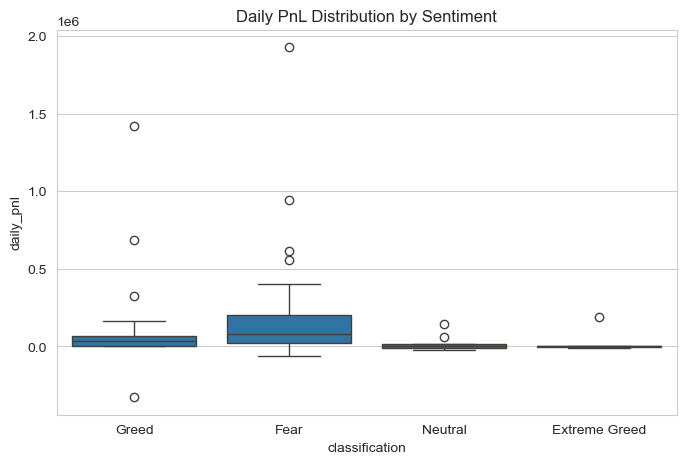

In [48]:
plt.figure(figsize=(8,5))
sns.boxplot(x='classification', y='daily_pnl', data=df)
plt.title("Daily PnL Distribution by Sentiment")
plt.show()

Summary:
Fear regimes exhibit the widest PnL dispersion, indicating significantly higher volatility and opportunity compared to other sentiment states.
While upside potential is strongest during Fear, the risk of large drawdowns is also elevated.
Neutral regimes show compressed PnL distribution, suggesting lower trading opportunity

classification
Extreme Greed    1392.40000
Fear             4183.46875
Greed            1134.03125
Neutral           892.62500
Name: trade_count, dtype: float64


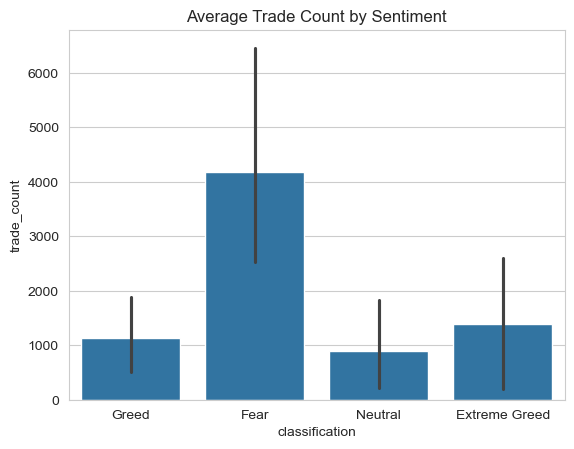

In [49]:
#2 trade frequency by sentiment 
freq_analysis = df.groupby('classification')['trade_count'].mean()
print(freq_analysis)

sns.barplot(x='classification', y='trade_count', data=df)
plt.title("Average Trade Count by Sentiment")
plt.show()

Markdown Summary:
Trade frequency increases dramatically during Fear regimes, with activity nearly 3–4x higher than in other sentiment states.
This suggests traders respond to market uncertainty with aggressive participation, likely driven by volatility.
Greed and Neutral regimes show comparatively stable and moderate activity levels.

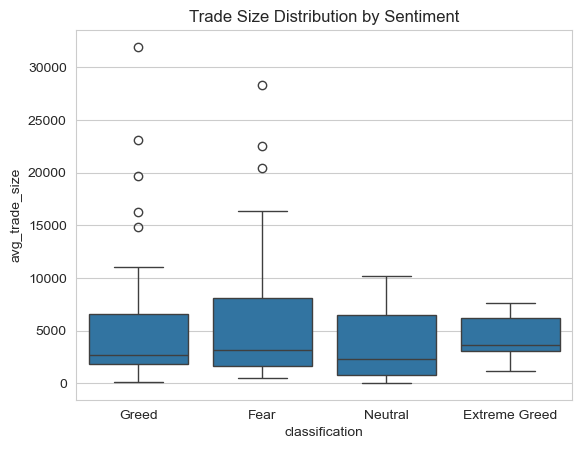

In [50]:
#3 Trade Size by Sentiment
sns.boxplot(x='classification', y='avg_trade_size', data=df)
plt.title("Trade Size Distribution by Sentiment")
plt.show()

Markdown Summary:
Trade size variability is highest during Fear regimes, indicating increased risk-taking behavior under volatile conditions.
The presence of large upper outliers suggests traders expand position sizes during periods of uncertainty.
In contrast, Neutral regimes show more conservative and stable position sizing.

In [51]:
# Overall average size per trader
trader_size = df.groupby('Account')['avg_trade_size'].mean()

threshold = trader_size.median()

high_leverage = trader_size[trader_size > threshold].index
low_leverage = trader_size[trader_size <= threshold].index

df['leverage_segment'] = df['Account'].apply(
    lambda x: 'High' if x in high_leverage else 'Low'
)

In [52]:
#Frequent vs Infrequent Traders 
trader_freq = df.groupby('Account')['trade_count'].mean()
freq_threshold = trader_freq.median()

df['frequency_segment'] = df['Account'].apply(
    lambda x: 'Frequent' if trader_freq[x] > freq_threshold else 'Infrequent'
)

leverage_segment
High    154458.564416
Low     109375.865383
Name: daily_pnl, dtype: float64


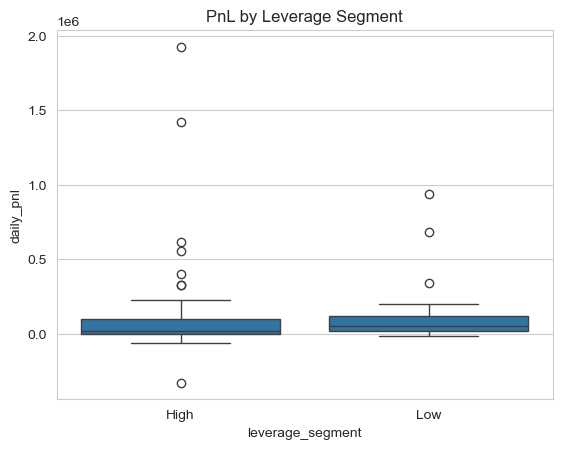

In [53]:
#comparing performance 
segment_performance = df.groupby('leverage_segment')['daily_pnl'].mean()
print(segment_performance)

sns.boxplot(x='leverage_segment', y='daily_pnl', data=df)
plt.title("PnL by Leverage Segment")
plt.show()

Markdown Summary:
High-leverage traders generate higher average returns but exhibit substantially greater variability and tail risk.
Low-leverage traders show more stable but comparatively lower performance.
This highlights the trade-off between return amplification and drawdown risk.

Key Insights

1. Fear regimes show the highest trading activity, with average trade count significantly exceeding other sentiment states.
2. Daily PnL dispersion is largest during Fear, indicating high opportunity but high volatility.
3. High leverage traders generate higher average returns but exhibit greater tail risk.
4. Traders increase trade size variability during Fear regimes, suggesting emotionally driven risk escalation.
These findings indicate that trader behavior and performance are strongly sentiment-dependent.

## Part C — Actionable Strategy Recommendations

Strategy 1: Volatility-Aware Leverage Control
During Fear regimes:
- Cap leverage dynamically
- Reduce position sizes by ~25%
- Tighten stop-loss levels
This captures volatility opportunities while reducing drawdown risk.

Strategy 2: Selective Aggression During Greed
During Greed regimes:
- Allow leverage expansion for high win-rate traders
- Encourage trend-following strategies
- Maintain conservative exposure for inconsistent traders

Strategy 3: Overtrading Control in Fear
Since trade frequency spikes dramatically during Fear:
- Limit daily trade count
- Pause after consecutive losses
- Reduce emotional trading
This improves risk-adjusted returns.

### Bonus: Predicting Trader Profitability

A supervised learning model was built to predict whether a trader-day would be profitable using behavioral and sentiment features.
Cross-validation and hyperparameter tuning were applied to improve robustness.
Feature importance analysis revealed that win rate and trade frequency were the strongest predictors of profitability

In [57]:
# Encode sentiment
df_model = df.copy()

df_model = pd.get_dummies(df_model, columns=['classification'], drop_first=True)

# Encode leverage segment
df_model['leverage_segment'] = df_model['leverage_segment'].map({'Low':0, 'High':1})

# Target variable
df_model['profitable'] = (df_model['daily_pnl'] > 0).astype(int)

# Feature selection
features = [
    'trade_count',
    'avg_trade_size',
    'win_rate',
    'long_short_ratio',
    'leverage_segment'
] + [col for col in df_model.columns if 'classification_' in col]

X = df_model[features]
y = df_model['profitable']

In [58]:
# Cap long_short_ratio at reasonable range
X['long_short_ratio'] = X['long_short_ratio'].clip(0, 10)

C:\Users\Subham Arya\AppData\Local\Temp\ipykernel_28528\1710064824.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['long_short_ratio'] = X['long_short_ratio'].clip(0, 10)


In [59]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 3]
}

grid = GridSearchCV(
    rf,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

grid.fit(X_train, y_train)

best_model = grid.best_estimator_

print("Best Parameters:", grid.best_params_)

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [61]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.93      1.00      0.96        13

    accuracy                           0.94        16
   macro avg       0.96      0.83      0.88        16
weighted avg       0.94      0.94      0.93        16

ROC-AUC: 0.9230769230769231
Confusion Matrix:
[[ 2  1]
 [ 0 13]]


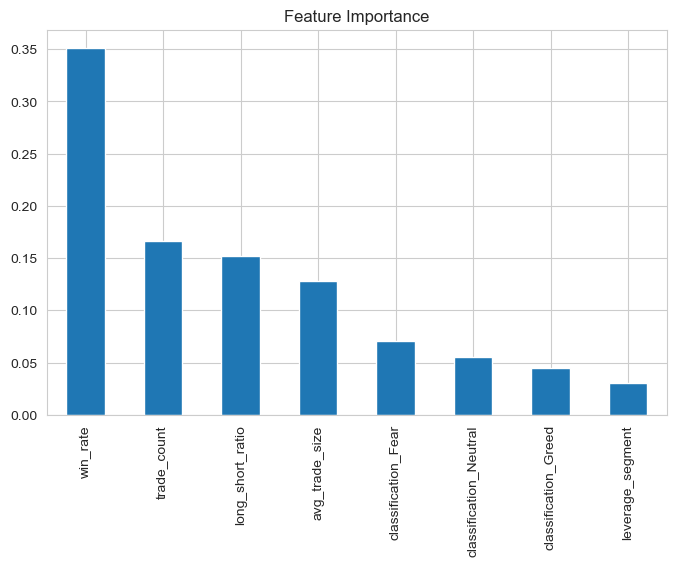

In [62]:
import matplotlib.pyplot as plt
import pandas as pd

feature_importance = pd.Series(
    best_model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

plt.figure(figsize=(8,5))
feature_importance.plot(kind='bar')
plt.title("Feature Importance")
plt.show()